In [1]:
# !pip install ucimlrepo
# !pip install xgboost

In [2]:
# Standard imports
import pandas as pd
import numpy as np

# load data
from ucimlrepo import fetch_ucirepo 

# ML Imports
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier

# paralelized computing
from joblib import Parallel, delayed

# MISC
import warnings

warnings.filterwarnings("ignore")

In [ ]:
## Study is on the 4 most popular datasets as of December 8th 2024 on UCI Machine Learning Repository
# 1. Letter Recognition: http://archive.ics.uci.edu/dataset/59/letter+recognition
# 2. Cover Type: http://archive.ics.uci.edu/dataset/31/covertype
# 3. Wine Quality: http://archive.ics.uci.edu/dataset/186/wine+quality
# 4. Adult: http://archive.ics.uci.edu/dataset/2/adult

## For models, we will be investigating
# 1. SVMs
# 2. Logistic Regression
# 3. Random Forest
# 4. Boosted Decision Tree with XGBoost 
# 5. KNNs

# Dataset
### loading and cleaning the datasets

In [4]:
## -------- Dataset Loading -------- 
# ---- Letter Recognition ----
letter_recognition = fetch_ucirepo(id=59) 
  
# data (as pandas dataframes) 
letter_recognition_X = letter_recognition.data.features 
letter_recognition_y = letter_recognition.data.targets 
  
# ---- cover type ----
# fetch dataset 
covertype = fetch_ucirepo(id=31) 
  
# data (as pandas dataframes) 
covertype_X = covertype.data.features 
covertype_y = covertype.data.targets 

# ---- Wine Quality ----
wine_quality = fetch_ucirepo(id=186) 
  
# data (as pandas dataframes) 
wine_quality_X = wine_quality.data.features 
wine_quality_y = wine_quality.data.targets 

# ---- Adult ----
adult = fetch_ucirepo(id=2) 
  
# data (as pandas dataframes) 
adult_X = adult.data.features 
adult_y = adult.data.targets 

In [5]:
# finding size of each data set
print("Number of Samples in Each Dataset")
print(f'Letter Recognition: {len(letter_recognition_X)}, Cover type: {len(covertype_X)}, Wine Quality: {len(wine_quality_X)}, Adult: {len(adult_X)}')

Number of Samples in Each Dataset
Letter Recognition: 20000, Cover type: 581012, Wine Quality: 6497, Adult: 48842


In [6]:
def encode_non_numeric(df):
    non_numeric_cols = df.select_dtypes(include=['object']).columns

    # Convert non-numeric columns to tokenized values using Label Encoding
    label_encoders = {}
    for col in non_numeric_cols:
        label_encoders[col] = LabelEncoder()
        df[col] = label_encoders[col].fit_transform(df[col].astype(str))

    return df, label_encoders

In [7]:
## -------- Dataset Cleaning -------- 
# ---- Letter Recognition ----
# Follow same strat as LETTER.p2, A-M is +1 and N-Z is negative 
def letter_to_numeric(letter):
    if 'A' <= letter <= 'M':  # A-M range
        return 1
    elif 'N' <= letter <= 'Z':  # N-Z range
        return 0

# Apply the function to the 'lettr' column
letter_recognition_y['converted_lettr'] = letter_recognition_y['lettr'].apply(letter_to_numeric)

# X Already in numeric for
letter_recognition_X = letter_recognition_X

# ---- cover type ----
# convert most popular class 2 to positive all native
covertype_y['converted_Cover_Type'] = covertype_y['Cover_Type'].apply(lambda x: 1 if x == 2 else 0)

# ---- Wine Quality ----
# if wine quality is >7 then 1 else -1
wine_quality_y['converted_quality'] = wine_quality_y['quality'].apply(lambda x: 1 if x >= 7 else 0)

# ---- Adult ----
# if 1 if > 50k else -1 
def income_to_numeric(income):
    return 1 if income == '>50K' else 0

# Apply the function to the 'income' column
adult_y['converted_income'] = adult_y['income'].apply(income_to_numeric)

# fixing X data
adult_X, adult_map = encode_non_numeric(adult_X)


# Models
### Training Code

In [8]:
import time
def train_with_5_cross_validation(X, y):
    # Train-test split configurations
    split_configurations = {
        "5000 Train, Rest Test": {"train_size": 5000, "test_size": None},
        "20% Train, 80% Test": {"train_size": 0.2, "test_size": 0.8},
        "50% Train, 50% Test": {"train_size": 0.5, "test_size": 0.5},
        "80% Train, 20% Test": {"train_size": 0.8, "test_size": 0.2}
    }

    # Models and their hyperparameter grids
    models_and_params = {
        "SVM": (SVC(kernel="rbf", random_state=42), {
            "C": [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 0.1, 1, 10],
        }),
        "Random Forest": (RandomForestClassifier(random_state=42), {
            "n_estimators": [100, 200, 300, 400, 500, 600, 700],
            "max_depth": [10, 20],
        }),
        "Logistic Regression": (LogisticRegression(max_iter=1000, random_state=42), {
            "C": [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 0.1, 1, 10, 100, 1000, 10000]
        }),
        "KNN": (KNeighborsClassifier(), {
            "n_neighbors": [2, 3, 4, 5, 6, 7, 8, 9, 10],
            "weights": ["uniform", "distance"]
        }),
        "XGBoost": (XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42), {
            "n_estimators": [100, 200],
            "learning_rate": [0.01, 0.1, 0.2],
            "max_depth": [3, 6, 9]
        }),
        "Naive Bayes": (GaussianNB(), {
            # Naive Bayes typically does not require hyperparameters to be tuned
        })
    }

    def process_split(X_train, X_test, y_train, y_test):
        # Initialize K-Fold cross-validation for 5 trials
        kf = KFold(n_splits=5, shuffle=True, random_state=42)

        # Store results
        results = {model_name: [] for model_name in models_and_params}
        best_model_tracker = {}

        for train_index, val_index in kf.split(X_train, y_train):
            # Split into training and validation sets
            X_train_fold, X_val = X_train[train_index], X_train[val_index]
            y_train_fold, y_val = y_train[train_index], y_train[val_index]

            for model_name in models_and_params:
                model, param_grid = models_and_params[model_name]

                # Perform GridSearchCV for hyperparameter tuning on the validation set
                grid_search = GridSearchCV(model, param_grid, scoring="accuracy", n_jobs=-1)
                grid_search.fit(X_train_fold, y_train_fold)

                # Get the best model and evaluate on the validation set
                best_model = grid_search.best_estimator_
                val_predictions = best_model.predict(X_val)
                val_accuracy = accuracy_score(y_val, val_predictions)

                results[model_name].append(val_accuracy)
                best_model_tracker[model_name] = best_model

        # Evaluate final performance on the test set
        final_test_results = {}
        for model_name, model in best_model_tracker.items():
            # Retrain the best model on the entire training set
            model.fit(X_train, y_train)

            # Evaluate on the test set
            test_predictions = model.predict(X_test)
            test_accuracy = accuracy_score(y_test, test_predictions)
            final_test_results[model_name] = test_accuracy

        return results, final_test_results

    # Store results for each configuration
    all_results = {}
    for config_name, config in split_configurations.items():
        print(f"\nProcessing configuration: {config_name}")

        start = time.time()
        
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, train_size=config["train_size"], test_size=config["test_size"], stratify=y, random_state=42
        )

        # Process this train-test split
        results, test_results = process_split(X_train, X_test, y_train, y_test)
        all_results[config_name] = (results, test_results)

        # Display results
        print("\nValidation Results (5-Fold Cross-Validation):")
        for model_name, accuracies in results.items():
            print(f"{model_name}: {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}")

        print("\nFinal Test Set Results:")
        for model_name, test_accuracy in test_results.items():
            print(f"{model_name}: {test_accuracy:.4f}")

        elapsed = time.time() - start
        print(f"time taken: {elapsed}")

    return all_results

In [9]:
print("============= Letter Model =============\n")
X, y = letter_recognition_X.values, letter_recognition_y['converted_lettr'].values
train_with_5_cross_validation(X, y)

============= Letter Model =============


Processing configuration: 5000 Train, Rest Test

Validation Results (5-Fold Cross-Validation):
SVM: 0.9148 ± 0.0085
Random Forest: 0.9376 ± 0.0036
Logistic Regression: 0.7234 ± 0.0140
KNN: 0.9556 ± 0.0019
XGBoost: 0.9516 ± 0.0022
Naive Bayes: 0.7014 ± 0.0103

Final Test Set Results:
SVM: 0.9205
Random Forest: 0.9480
Logistic Regression: 0.7239
KNN: 0.9573
XGBoost: 0.9495
Naive Bayes: 0.7042
time taken: 321.89192724227905

Processing configuration: 20% Train, 80% Test

Validation Results (5-Fold Cross-Validation):
SVM: 0.9107 ± 0.0102
Random Forest: 0.9313 ± 0.0070
Logistic Regression: 0.7257 ± 0.0130
KNN: 0.9435 ± 0.0088
XGBoost: 0.9353 ± 0.0086
Naive Bayes: 0.6997 ± 0.0086

Final Test Set Results:
SVM: 0.9177
Random Forest: 0.9441
Logistic Regression: 0.7248
KNN: 0.9529
XGBoost: 0.9477
Naive Bayes: 0.7039
time taken: 246.3216803073883

Processing configuration: 50% Train, 50% Test

Validation Results (5-Fold Cross-Validation):
SVM: 0.9346 ± 0

{'5000 Train, Rest Test': ({'SVM': [0.922, 0.926, 0.915, 0.903, 0.908],
   'Random Forest': [0.937, 0.943, 0.933, 0.935, 0.94],
   'Logistic Regression': [0.719, 0.735, 0.73, 0.735, 0.698],
   'KNN': [0.954, 0.956, 0.953, 0.958, 0.957],
   'XGBoost': [0.955, 0.95, 0.949, 0.951, 0.953],
   'Naive Bayes': [0.712, 0.705, 0.696, 0.71, 0.684]},
  {'SVM': 0.9204666666666667,
   'Random Forest': 0.948,
   'Logistic Regression': 0.7239333333333333,
   'KNN': 0.9573333333333334,
   'XGBoost': 0.9494666666666667,
   'Naive Bayes': 0.7042}),
 '20% Train, 80% Test': ({'SVM': [0.9075, 0.92875, 0.89875, 0.905, 0.91375],
   'Random Forest': [0.9325, 0.94375, 0.92875, 0.92875, 0.9225],
   'Logistic Regression': [0.70875, 0.73375, 0.715, 0.745, 0.72625],
   'KNN': [0.945, 0.9575, 0.94375, 0.93, 0.94125],
   'XGBoost': [0.9375, 0.94375, 0.94, 0.91875, 0.93625],
   'Naive Bayes': [0.715, 0.69625, 0.68875, 0.70125, 0.6975]},
  {'SVM': 0.9176875,
   'Random Forest': 0.944125,
   'Logistic Regression': 0.72

In [10]:
print("\n============= Wine Quality Model =============\n")
X, y = wine_quality_X.values, wine_quality_y['converted_quality'].values
train_with_5_cross_validation(X, y)


============= Wine Quality Model =============


Processing configuration: 5000 Train, Rest Test

Validation Results (5-Fold Cross-Validation):
SVM: 0.8034 ± 0.0102
Random Forest: 0.8842 ± 0.0115
Logistic Regression: 0.8170 ± 0.0105
KNN: 0.8480 ± 0.0043
XGBoost: 0.8746 ± 0.0077
Naive Bayes: 0.7472 ± 0.0059

Final Test Set Results:
SVM: 0.8036
Random Forest: 0.8858
Logistic Regression: 0.8243
KNN: 0.8504
XGBoost: 0.8724
Naive Bayes: 0.7602
time taken: 338.099937915802

Processing configuration: 20% Train, 80% Test

Validation Results (5-Fold Cross-Validation):
SVM: 0.8037 ± 0.0252
Random Forest: 0.8491 ± 0.0177
Logistic Regression: 0.8306 ± 0.0179
KNN: 0.8245 ± 0.0237
XGBoost: 0.8476 ± 0.0183
Naive Bayes: 0.7644 ± 0.0164

Final Test Set Results:
SVM: 0.8034
Random Forest: 0.8451
Logistic Regression: 0.8155
KNN: 0.8103
XGBoost: 0.8349
Naive Bayes: 0.7578
time taken: 141.98096895217896

Processing configuration: 50% Train, 50% Test

Validation Results (5-Fold Cross-Validation):
SVM: 0.80

{'5000 Train, Rest Test': ({'SVM': [0.82, 0.794, 0.808, 0.803, 0.792],
   'Random Forest': [0.894, 0.881, 0.883, 0.898, 0.865],
   'Logistic Regression': [0.835, 0.813, 0.809, 0.822, 0.806],
   'KNN': [0.854, 0.85, 0.841, 0.849, 0.846],
   'XGBoost': [0.883, 0.882, 0.875, 0.871, 0.862],
   'Naive Bayes': [0.753, 0.743, 0.738, 0.753, 0.749]},
  {'SVM': 0.8036072144288577,
   'Random Forest': 0.8857715430861723,
   'Logistic Regression': 0.824315297261189,
   'KNN': 0.8503674014696059,
   'XGBoost': 0.8724114896459586,
   'Naive Bayes': 0.760187040748163}),
 '20% Train, 80% Test': ({'SVM': [0.8538461538461538,
    0.7884615384615384,
    0.7884615384615384,
    0.7923076923076923,
    0.7953667953667953],
   'Random Forest': [0.8807692307692307,
    0.8307692307692308,
    0.8461538461538461,
    0.8346153846153846,
    0.8532818532818532],
   'Logistic Regression': [0.8576923076923076,
    0.8115384615384615,
    0.8423076923076923,
    0.8115384615384615,
    0.8301158301158301],
   'K

In [11]:
print("\n============= Adult Model =============\n")
X, y = adult_X.values, adult_y['converted_income'].values
train_with_5_cross_validation(X, y)


============= Adult Model =============


Processing configuration: 5000 Train, Rest Test

Validation Results (5-Fold Cross-Validation):
SVM: 0.8378 ± 0.0106
Random Forest: 0.8606 ± 0.0137
Logistic Regression: 0.8364 ± 0.0124
KNN: 0.8404 ± 0.0107
XGBoost: 0.8654 ± 0.0105
Naive Bayes: 0.8334 ± 0.0119

Final Test Set Results:
SVM: 0.8395
Random Forest: 0.8547
Logistic Regression: 0.8414
KNN: 0.8423
XGBoost: 0.8584
Naive Bayes: 0.8323
time taken: 261.81453251838684

Processing configuration: 20% Train, 80% Test

Validation Results (5-Fold Cross-Validation):
SVM: 0.8395 ± 0.0085
Random Forest: 0.8573 ± 0.0084
Logistic Regression: 0.8394 ± 0.0126
KNN: 0.8446 ± 0.0080
XGBoost: 0.8616 ± 0.0132
Naive Bayes: 0.8325 ± 0.0076

Final Test Set Results:
SVM: 0.8416
Random Forest: 0.8593
Logistic Regression: 0.8403
KNN: 0.8455
XGBoost: 0.8609
Naive Bayes: 0.8324
time taken: 467.5575842857361

Processing configuration: 50% Train, 50% Test

Validation Results (5-Fold Cross-Validation):
SVM: 0.8454 ± 0

{'5000 Train, Rest Test': ({'SVM': [0.845, 0.853, 0.825, 0.839, 0.827],
   'Random Forest': [0.873, 0.877, 0.848, 0.863, 0.842],
   'Logistic Regression': [0.845, 0.85, 0.827, 0.843, 0.817],
   'KNN': [0.843, 0.859, 0.834, 0.839, 0.827],
   'XGBoost': [0.877, 0.878, 0.86, 0.861, 0.851],
   'Naive Bayes': [0.84, 0.845, 0.829, 0.841, 0.812]},
  {'SVM': 0.8394690023265362,
   'Random Forest': 0.8546599151498563,
   'Logistic Regression': 0.841430591670088,
   'KNN': 0.8423201496282104,
   'XGBoost': 0.8584234295880663,
   'Naive Bayes': 0.8323069203047306}),
 '20% Train, 80% Test': ({'SVM': [0.8500511770726714,
    0.827021494370522,
    0.8352098259979529,
    0.837173579109063,
    0.847926267281106],
   'Random Forest': [0.8541453428863869,
    0.8428863868986693,
    0.8592630501535312,
    0.8627752176139273,
    0.8673835125448028],
   'Logistic Regression': [0.853121801432958,
    0.81985670419652,
    0.8357215967246674,
    0.8351254480286738,
    0.8530465949820788],
   'KNN': [

In [ ]:
print("\n============= Cover Type Model =============\n")
X, y = covertype_X.values, covertype_y['converted_Cover_Type'].values
train_with_5_cross_validation(X, y)


============= Cover Type Model =============


Processing configuration: 5000 Train, Rest Test

Validation Results (5-Fold Cross-Validation):
SVM: 0.7302 ± 0.0081
Random Forest: 0.8142 ± 0.0074
Logistic Regression: 0.7190 ± 0.0144
KNN: 0.7740 ± 0.0188
XGBoost: 0.8228 ± 0.0105
Naive Bayes: 0.6640 ± 0.0147

Final Test Set Results:
SVM: 0.7246
Random Forest: 0.8123
Logistic Regression: 0.7107
KNN: 0.7823
XGBoost: 0.8193
Naive Bayes: 0.6601
time taken: 856.1814024448395

Processing configuration: 20% Train, 80% Test


# Plotting Sample Efficiency

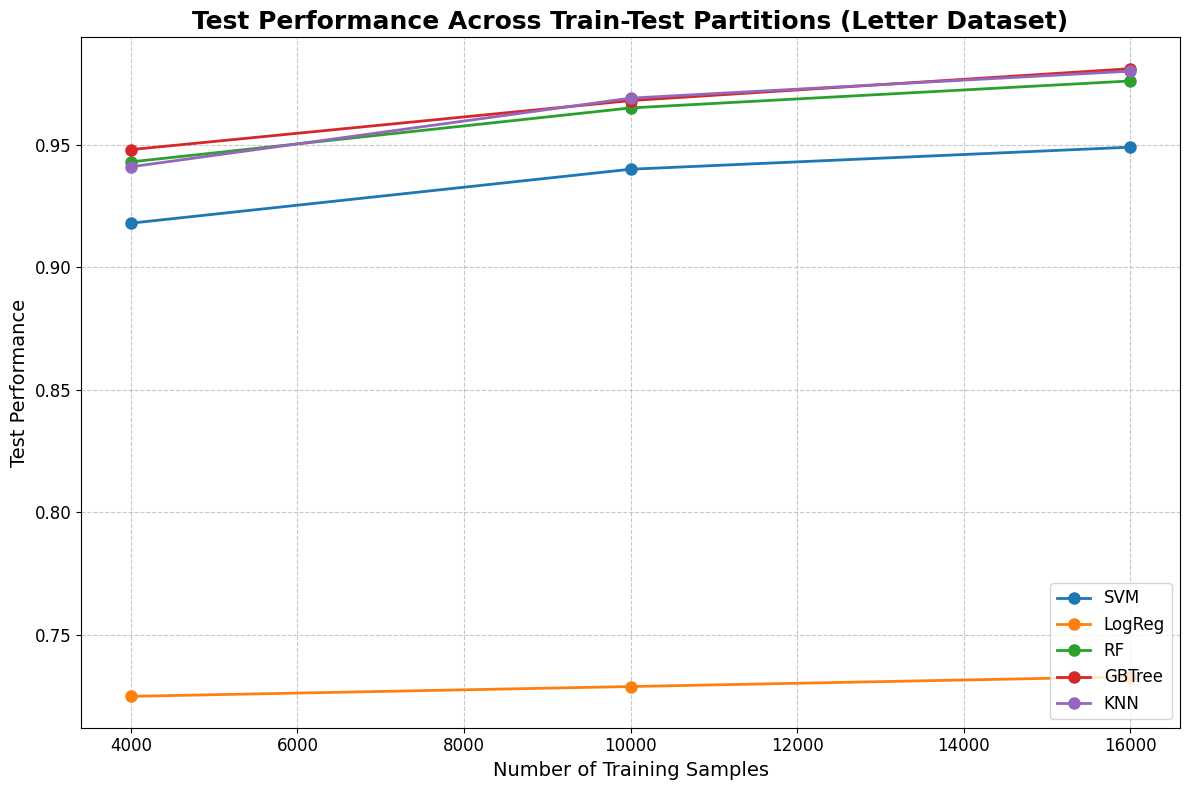

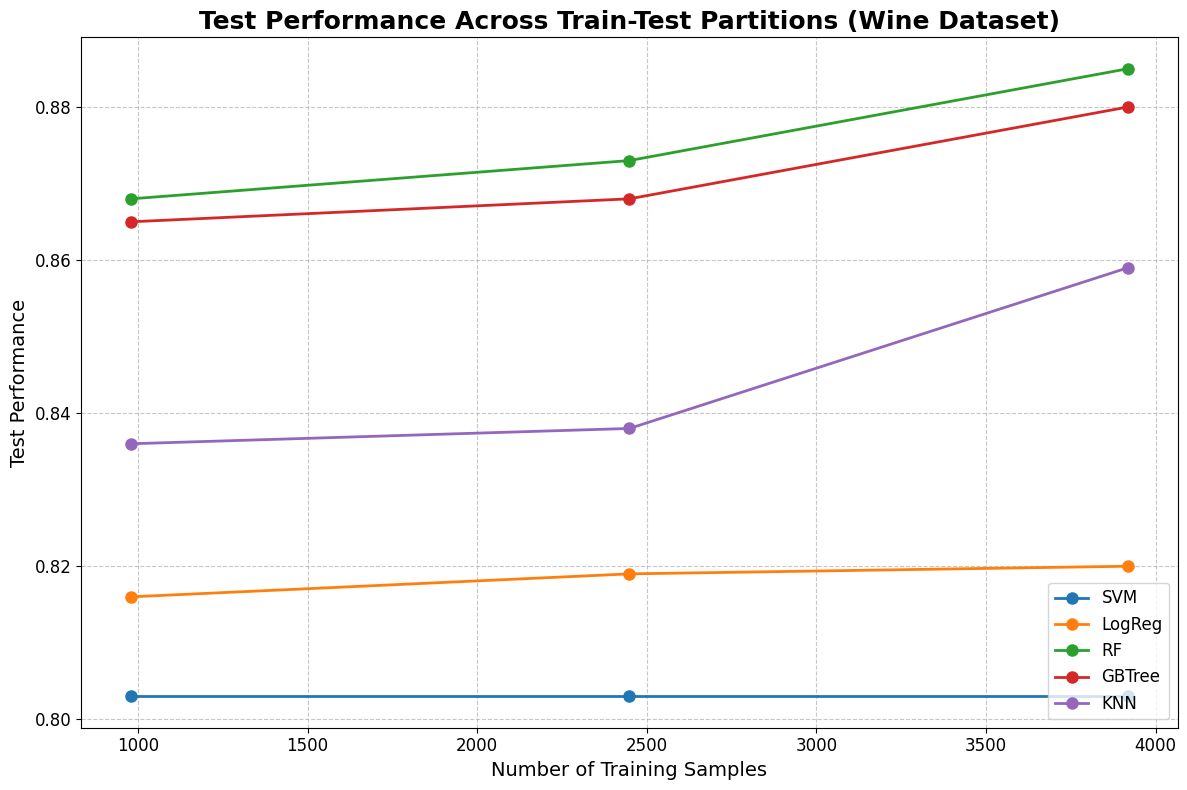

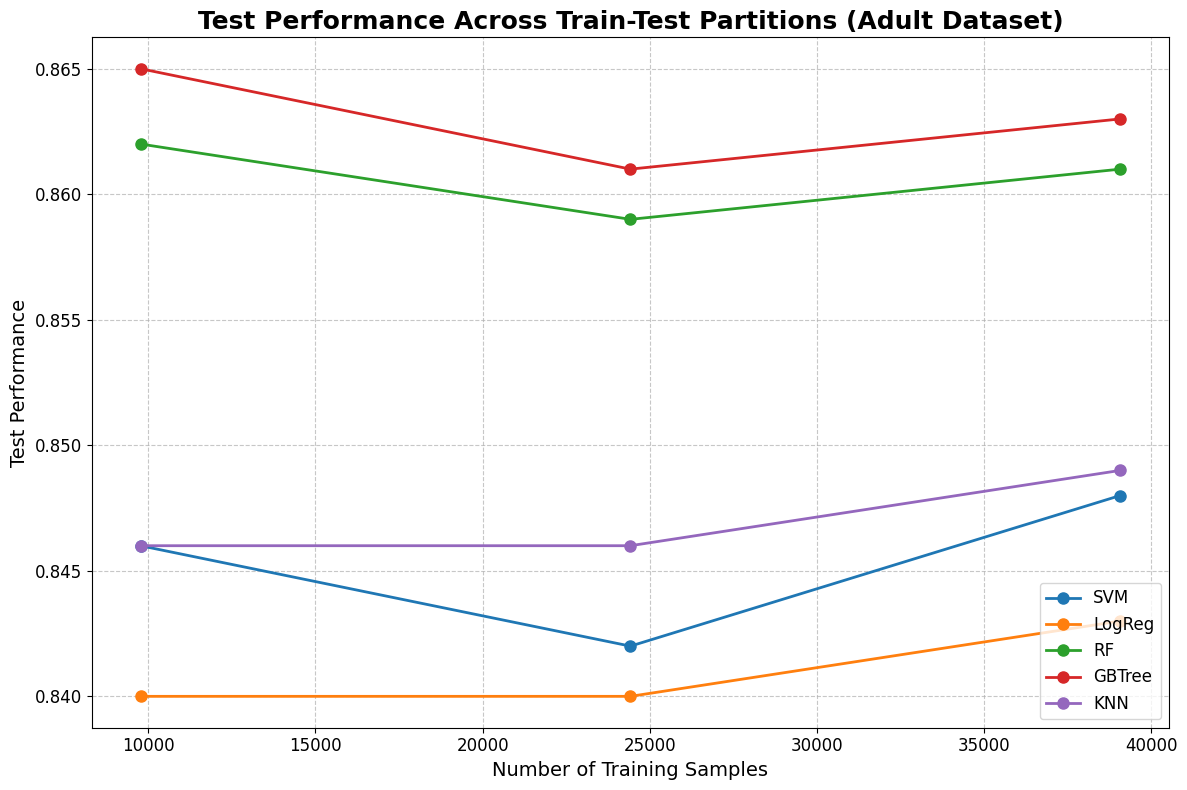

In [5]:
# Sample efficieny visualization
import matplotlib.pyplot as plt

# Data for models on each dataset
data = {
    "Letter": {
        "samples": [20000 *0.2, 20000 *0.5, 20000 *0.8],
        "models": {
            "SVM": [0.918, 0.940, 0.949],
            "LogReg": [0.725, 0.729, 0.733],
            "RF": [0.943, 0.965, 0.976],
            "GBTree": [0.948, 0.968, 0.981],
            "KNN": [0.941, 0.969, 0.980],
        },
    },
    "Wine": {
        "samples": [4898 * 0.2, 4898* 0.5, 4898 * 0.8],
        "models": {
            "SVM": [0.803, 0.803, 0.803],
            "LogReg": [0.816, 0.819, 0.820],
            "RF": [0.868, 0.873, 0.885],
            "GBTree": [0.865, 0.868, 0.880],
            "KNN": [0.836, 0.838, 0.859],
        },
    },
    "Adult": {
        "samples": [48842 * 0.2, 48842 * 0.5, 48842 * 0.8],
        "models": {
            "SVM": [0.846, 0.842, 0.848],
            "LogReg": [0.840, 0.840, 0.843],
            "RF": [0.862, 0.859, 0.861],
            "GBTree": [0.865, 0.861, 0.863],
            "KNN": [0.846, 0.846, 0.849],
        },
    },
}

# Plot each dataset in a separate graph
for dataset, dataset_data in data.items():
    samples = dataset_data["samples"]
    models = dataset_data["models"]

    plt.figure(figsize=(12, 8))
    for model, performance in models.items():
        plt.plot(samples, performance, marker='o', linewidth=2, markersize=8, label=model)

    plt.title(f"Test Performance Across Train-Test Partitions ({dataset} Dataset)", fontsize=18, weight='bold')
    plt.xlabel("Number of Training Samples", fontsize=14)
    plt.ylabel("Test Performance", fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(fontsize=12, loc='lower right')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
